In [ ]:
pip install jax

In [ ]:
import jax.numpy as jnp
import jax

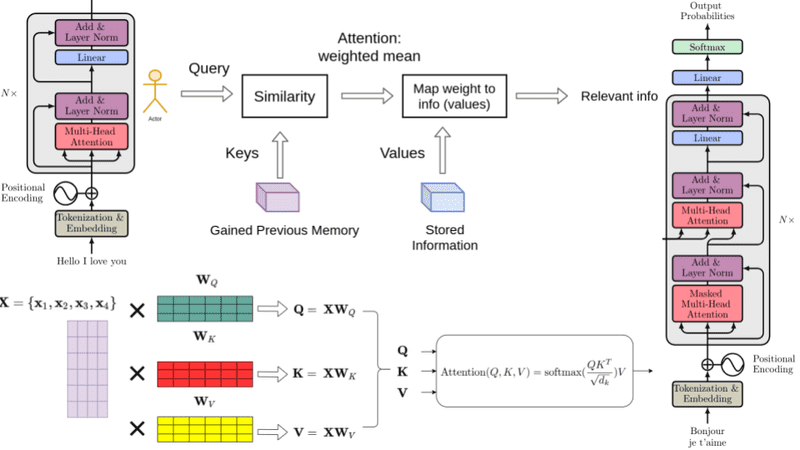

In [ ]:
import numpy as np
import time
np.random.seed(0)
#
# Ocultar las GEMM que no corresponden a heads
#
def transformer_block(b, l, d, h, f,
                      EI,
                      WQ, WK, WV,
                      WO,
                      W1, W2,
                      timers):

    # Auxiliary variables
    lh  = l*h
    lb  = l*b
    assert(d % h == 0)
    ddh = int(d / h)

    # Auxiliary arrays
    E1 = np.zeros((l,l),  dtype='float32')
    E2 = np.zeros((d,lb), dtype='float32')
    E3 = np.zeros((f,lb), dtype='float32')

    # Timers
    if (timers):
        temp   = {'M1': 0.0, 'M4':  0.0, 'M5':  0.0, 'M6':  0.0, 'M7':  0.0, 'M8':  0.0,
                  'M9': 0.0, 'M10': 0.0, 'F11': 0.0, 'F12': 0.0, 'F13': 0.0, 'F14': 0.0  }
        gflops = {'M1': 0.0, 'M4':  0.0, 'M5':  0.0, 'M6':  0.0, 'M7':  0.0, 'M8':  0.0,
                  'M9': 0.0, 'M10': 0.0, 'F11': 0.0, 'F12': 0.0, 'F13': 0.0, 'F14': 0.0  }

    #######################################
    # MHA
    #######################################

    # M1--M3: (Q, K, V) = (WQ, WK, WV) * EI
    if (timers):
        tini = time.time()
    Q = WQ @ EI # assert(Q.shape==(d,lb))
    K = WK @ EI # assert(K.shape==(d,lb))
    V = WV @ EI # assert(V.shape==(d,lb))
    if (timers):
        tfin = time.time() - tini
        temp['M1']   = tfin
        gflops['M1'] = 3*2.0*(d*d*l*b)/(tfin*1.0e+9)

    # M4. Split --> Transparent

    # Process b sequences and h heads
    for j in range(b):
        indJ = j*l
        for i in range(h):
            indI1 = i*l
            indI2 = i*ddh

            # if (timers):
                # tini = time.time()
            # M5. E^{i,j} = (K^{i,j})^T * Q^{i,j}
            if (timers):
                tini = time.time()
            E1 = K[indI2:indI2+ddh,indJ:indJ+l].transpose() @ Q[indI2:indI2+ddh,indJ:indJ+l] # assert(E1.shape==(l,l))
            if (timers):
                tfin = time.time() - tini
                temp['M5'] += tfin
            # if (timers):
                # tfin = time.time() - tini
                # temp['M5']   = tfin
                # gflops['M5'] += 2.0*(d*d*l*b)/(tfin*1.0e+9)

            # M6. Softmax
            # ################# Pending Softmax

            # M7. E2^{i,j} = V^{i,j] * E1^{i,j}
            if (timers):
                tini = time.time()
            E2[indI2:indI2+ddh,indJ:indJ+l] = V[indI2:indI2+ddh,indJ:indJ+l] @ E1 # assert(E2[indI2:indI2+ddh,indJ:indJ+l].shape==(ddh,l))
            if (timers):
                tfin = time.time() - tini
                temp['M7'] += tfin

    if (timers):
        gflops['M5'] = (b*h)*2.0*(l*l*ddh)/(temp['M5']*1.0e+9)
        gflops['M7'] = (b*h)*2.0*(ddh*l*l)/(temp['M7']*1.0e+9)

    # M8. Concatenate --> Transparent

    # M9. AOb = WO * E2
    # M10. AO = Lnorm(AOb + EI)
    if (timers):
        tini = time.time()
    AO = EI + WO @ E2 # assert(AO.shape==(d,lb))
    if (timers):
        tfin = time.time() - tini
        temp['M9']   = tfin
        gflops['M9'] = 2.0*(d*l*b*d)/(tfin*1.0e+9)
    # ################# Pending Lnorm

    #######################################
    # FFN
    #######################################

    # F11. E3b = W1 * AO
    if (timers):
        tini = time.time()
    E3 = W1 @ AO # assert(E3.shape==(f,lb))
    if (timers):
        tfin = time.time() - tini
        temp['F11']   = tfin
        gflops['F11'] = 2.0*(f*lb*d)/(tfin*1.0e+9)

    # F12. E3 = GELU(E3b)
    # ################# Pending GELU

    # F13. EOb = W2 * E3
    # F14. EO = Lnorm(EOb + AO)
    if (timers):
        tini = time.time()
    EO = AO + W2 @ E3 # assert(EO.shape==(d,lb))
    if (timers):
        tfin = time.time() - tini
        temp['F13']   = tfin
        gflops['F13'] = 2.0*(d*lb*f)/(tfin*1.0e+9)
    # ################# Pending Lnorm

    return (EO, temp, gflops)

def generate_transformer_block(b, l, d, h, f):
#
    lb  = l*b
#
    EI = np.random.rand(d,lb)-0.5
#
    WQ = np.random.rand(d,d)-0.5
    WK = np.random.rand(d,d)-0.5
    WV = np.random.rand(d,d)-0.5
#
    WO = np.random.rand(d,d)-0.5
#
    W1 = np.random.rand(f,d)-0.5
    W2 = np.random.rand(d,f)-0.5
#
    return (EI, WQ, WK, WV, WO, W1, W2)

# Input
b = 32
l = 128
#
# BERT-base
#
# d = 768
# h = 12
# f = 4 * d
#
# BERT-large
#
d = 1024
h = 16
f = 4 * d
#
timers = 1
#
(EI, WQ, WK, WV, WO, W1, W2) = generate_transformer_block(b, l, d, h, f)
(EO, temp, gflops) = transformer_block(b, l, d, h, f, EI.copy(), WQ, WK, WV, WO, W1, W2, timers)
#
if (timers):
    print('Time( M1)   = {:.4f} s'.format(temp['M1']))
    print('Time( M5)   = {:.4f} s'.format(temp['M5']))
    print('Time( M7)   = {:.4f} s'.format(temp['M7']))
    print('Time( M9)   = {:.4f} s'.format(temp['M9']))
    print('Time(F11)   = {:.4f} s'.format(temp['F11']))
    print('Time(F13)   = {:.4f} s'.format(temp['F13']))

    print('Gflops( M1) = {:6.2f}'.format(gflops['M1']))
    print('Gflops( M5) = {:6.2f}'.format(gflops['M5']))
    print('Gflops( M7) = {:6.2f}'.format(gflops['M7']))
    print('Gflops( M9) = {:6.2f}'.format(gflops['M9']))
    print('Gflops(F11) = {:6.2f}'.format(gflops['F11']))
    print('Gflops(F13) = {:6.2f}'.format(gflops['F13']))

Time( M1)   = 1.9502 s
Time( M5)   = 0.1548 s
Time( M7)   = 0.1167 s
Time( M9)   = 0.5956 s
Time(F11)   = 2.2213 s
Time(F13)   = 2.3222 s
Gflops( M1) =  13.21
Gflops( M5) =   6.94
Gflops( M7) =   9.20
Gflops( M9) =  14.42
Gflops(F11) =  15.47
Gflops(F13) =  14.80
